## Importing packages

In [ ]:
!pip install tensorflow --upgrade --quiet

In [ ]:
!yes | apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

In [ ]:
import tensorflow as tf
import numpy as np
import os
import shutil 
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from zipfile import ZipFile, error
from tqdm import tqdm
from pathlib import Path
import math

tfk = tf.keras
tfkl = tf.keras.layers

2023-01-19 08:34:27.977352: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-19 08:34:29.701969: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-01-19 08:34:29.702200: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Co

In [ ]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [ ]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
# Dataset folders 
dataset_dir = '/kaggle/input/biomedicine-data-splitted-patient/data_splitted_patient'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

## Prefetch

In [ ]:
image_size = 400
batch_size_data = 8

In [ ]:
train_gen = tf.keras.utils.image_dataset_from_directory(
    training_dir,
    validation_split=0.0,
    shuffle=True,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size_data)

Found 10992 files belonging to 3 classes.


In [ ]:
valid_gen = tf.keras.utils.image_dataset_from_directory(
    validation_dir,
    validation_split=0.0,
    shuffle=False,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size_data)

Found 2487 files belonging to 3 classes.


In [ ]:
test_gen = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    validation_split=0.0,
    shuffle=False,
    seed=seed,
    image_size=(image_size, image_size),
    batch_size=batch_size_data)

Found 1991 files belonging to 3 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
train_gen = train_gen.prefetch(buffer_size=AUTOTUNE)
valid_gen = valid_gen.prefetch(buffer_size=AUTOTUNE)
test_gen = test_gen.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Use one-hot encoding for labels
class_names = ["N","P","T"]
train_gen = train_gen.map(lambda x, y: (x, tf.one_hot(y, depth=len(class_names))))
valid_gen = valid_gen.map(lambda x, y: (x, tf.one_hot(y, depth=len(class_names))))
test_gen = test_gen.map(lambda x, y: (x, tf.one_hot(y, depth=len(class_names))))

# Weights

In [ ]:
class_names = ['N','P','T']
class_samples = [0] * len(class_names)

In [ ]:
for i, class_name in enumerate(class_names):
    class_dir = '{}/{}/'.format(training_dir, class_name)
    class_samples[i] = len(os.listdir(class_dir))

In [ ]:
total_samples = sum(class_samples)
class_weight = list(total_samples / (len(class_names) * np.array(class_samples)))
class_weight = {i: class_weight[i] for i in range(len(class_weight))}

In [ ]:
print('Class weights: {}'.format(class_weight))

Class weights: {0: 0.5512261170452836, 1: 1.2112396694214875, 2: 2.775757575757576}


# Model

In [ ]:
input_shape = (image_size, image_size, 3)
epochs = 25
batch_size = 256
patience = 25

In [ ]:
def scratch(input_shape):

    input_layer = tfkl.Input(shape=input_shape, name='input_layer') 
    
    # Build the neural network layer by layer      
    conv = tfkl.Conv2D(
        filters=128,
        kernel_size=7,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(input_layer)
    conv = tfkl.MaxPooling2D()(conv)

    
    conv = tfkl.Conv2D(
        filters=128,
        kernel_size=7,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv)
    conv = tfkl.MaxPooling2D()(conv)

    
    conv = tfkl.Conv2D(
        filters=256,
        kernel_size=5,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv)
    conv = tfkl.MaxPooling2D()(conv)


    conv = tfkl.Conv2D(
        filters=256,
        kernel_size=5,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv)
    conv = tfkl.MaxPooling2D()(conv)
    
    dropout = tfkl.Dropout(0.3)(conv)

    
    conv = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(dropout)
    conv = tfkl.MaxPooling2D()(conv)
    
    conv = tfkl.Conv2D(
        filters=512,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv)
    conv = tfkl.MaxPooling2D()(conv)
    
    conv = tfkl.Conv2D(
        filters=1024,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv)
    conv = tfkl.MaxPooling2D()(conv)
    
    conv = tfkl.Conv2D(
        filters=2048,
        kernel_size=3,
        padding = 'same',
        activation = 'relu',
        kernel_initializer = tfk.initializers.HeUniform(seed)
    )(conv)
    conv = tfkl.MaxPooling2D()(conv)
    
    dropout = tfkl.Dropout(0.3)(conv)



    x = tfkl.GlobalAveragePooling2D(name='gap')(dropout)
    classifier_layer = tfkl.Dense(
        units=1024, 
        name='Classifier', 
        kernel_initializer=tfk.initializers.HeUniform(seed), 
        kernel_regularizer=tfk.regularizers.L1L2(l1=1e-4, l2=1e-3),
        activation='relu')(x)
    dropout = tfkl.Dropout(0.3)(classifier_layer)
    output_layer = tfkl.Dense(units=3, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed), name='output_layer')(dropout)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(0.0001), metrics='accuracy')

    # Return the model
    return model

# Training

In [ ]:
# Build model (for NO augmentation training)
SCR = scratch(input_shape)
SCR.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 400, 400, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 400, 400, 128)     18944     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 200, 200, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 128)     802944    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 100, 100, 128)    0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 100, 100, 256)     819456

In [ ]:
# Train the model
SCR_history = SCR.fit(
    x = train_gen,
    batch_size = batch_size,
    epochs = 35,
    validation_data = valid_gen,
    class_weight=class_weight,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=patience, restore_best_weights=True)
        ],
).history

Epoch 1/35


2023-01-19 08:34:59.472837: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


1374/1374 [==============================] - 781s 557ms/step - loss: 15.9077 - accuracy: 0.4934 - val_loss: 7.1928 - val_accuracy: 0.5794
Epoch 2/35
1374/1374 [==============================] - 765s 556ms/step - loss: 6.9654 - accuracy: 0.5810 - val_loss: 6.6813 - val_accuracy: 0.5891
Epoch 3/35
1374/1374 [==============================] - 766s 557ms/step - loss: 6.5031 - accuracy: 0.6167 - val_loss: 6.1991 - val_accuracy: 0.6397
Epoch 4/35
1374/1374 [==============================] - 765s 556ms/step - loss: 5.9447 - accuracy: 0.6665 - val_loss: 5.5790 - val_accuracy: 0.7604
Epoch 5/35
1374/1374 [==============================] - 760s 552ms/step - loss: 5.3272 - accuracy: 0.7090 - val_loss: 5.0731 - val_accuracy: 0.7141
Epoch 6/35
1374/1374 [==============================] - 755s 549ms/step - loss: 4.6114 - accuracy: 0.7529 - val_loss: 4.1605 - val_accuracy: 0.8191
Epoch 7/35
1374/1374 [==============================] - 749s 544ms/step - loss: 3.7972 - accuracy: 0.7959 - val_loss: 3.67

# Performances

In [ ]:
# Save the best model
SCR.save('ScratchModel')

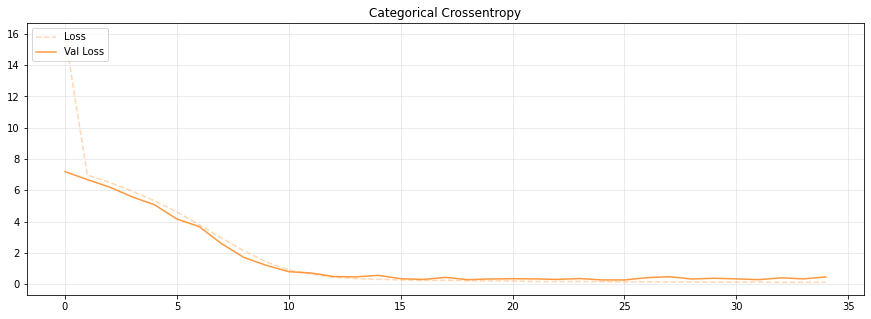

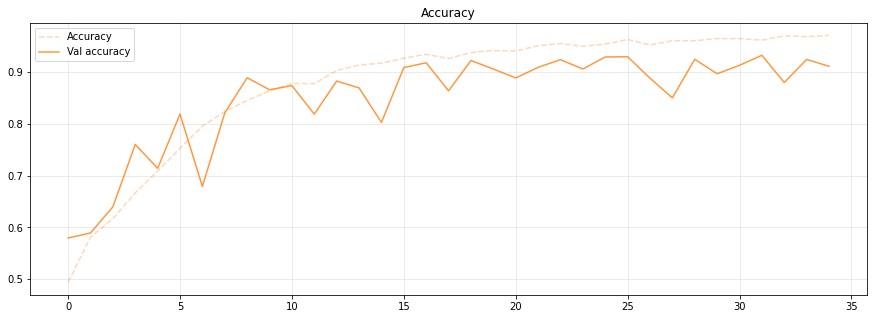

In [ ]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(SCR_history['loss'], label='Loss', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(SCR_history['val_loss'], label='Val Loss', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(SCR_history['accuracy'], label='Accuracy', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(SCR_history['val_accuracy'], label='Val accuracy', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)
plt.savefig('SCR_v1.1.0_acc.png')

plt.show()

In [ ]:
best_score = max(SCR_history['accuracy'])
best_score_val = max(SCR_history['val_accuracy'])

print("Max train accuracy obtained with this model:", best_score)
print("Max val accuracy obtained with this model:", best_score_val)

Max train accuracy obtained with this model: 0.9714337587356567
Max val accuracy obtained with this model: 0.9328508377075195


# Confusion matrix

In [ ]:
# Compute the prediction on the valid data
predictions = SCR.predict(valid_gen)
y_predicted = tf.argmax(predictions, axis=-1)

311/311 [==============================] - 39s 124ms/step


In [ ]:
# Take all the true labels and save them in an array
y_true =  np.array([])
count = 0
for x, y in valid_gen:
  count += 1
  y_true = np.concatenate([y_true, np.argmax(y, axis=-1)])

print("There are {} batches of images in the validation set".format(count))

There are 311 batches of images in the validation set


Accuracy: 0.9115
Precision: 0.8706
Recall: 0.8946
F1: 0.8814


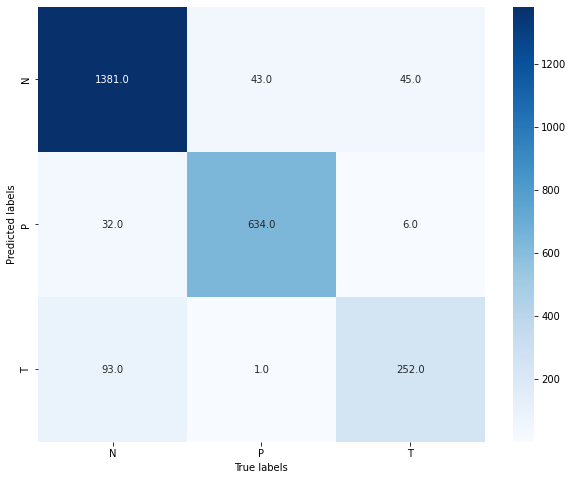

In [ ]:
# Compute the confusion matrix
cm = confusion_matrix(y_true, y_predicted)

# Compute the classification metrics
accuracy = accuracy_score(y_true, y_predicted)
precision = precision_score(y_true, y_predicted, average='macro')
recall = recall_score(y_true, y_predicted, average='macro')
f1 = f1_score(y_true, y_predicted, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=class_names, yticklabels=class_names, annot=True, fmt=".1f", cmap="Blues")
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.savefig('SCR_v1.1.0_conf.png')

plt.show()